In [ ]:
# import computational packages
import numpy as np
import pandas as pd 

# sparse matrix
from scipy.io import mmread

# import modeling packages
from scipy.stats import chi2, nbinom
from scipy.optimize import minimize, dual_annealing

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white');
plt.rcParams['figure.figsize'] = (10, 10)

# higher resolution plots
%config InlineBackend.figure_format ='retina'

In [36]:
def get_input_and_output_vectors(spacer_sequence, proximal_genes):
    '''helper function to get input and output vectors'''
    
    # get sample of data for cells with guide
    guide_present = cell_ts_matrix.loc[spacer_sequence] == 1
    guide_cells = cell_ts_matrix.loc[spacer_sequence][guide_present]
    guide_cells = guide_cells.sample(min(len(guide_cells), 5000), random_state=1)
    
    # get sample of data for cells without guide
    no_guide_cells = cell_ts_matrix.loc[spacer_sequence][~guide_present]
    no_guide_cells = no_guide_cells.sample(min(len(no_guide_cells), 5000), random_state=1)
    
    # get merged dataframe with sampled input and output
    input_series = pd.concat([guide_cells, no_guide_cells])
    output_series = count_matrix_df.loc[proximal_genes]
    # output_series = output_series[output_series < 60]
    output_series = output_series[output_series.index.isin(input_series.index)]
    output_series = output_series.sample(frac=1)
    input_output_df = pd.merge(input_series, output_series, left_index=True, right_index=True)
    
    # get input and output vectors as np.arrays (for faster computation)
    input_vector = input_output_df.iloc[:, 0].values
    output_vector = input_output_df.iloc[:, 1].sample(frac=1).values
    
    return input_vector, output_vector, input_output_df.index


def adjust_index(covariate, idx):
    '''adjusts index of covariate to match input and output vectors'''
    
    index_df = pd.DataFrame(idx).set_index(0)
    covariate_df = index_df.merge(covariate, left_index=True, right_index=True)
    # print(covariate_df)
    # print(covariate_df.iloc[:, 0].values)
    return covariate_df.iloc[:, 0].values


def divide_by_guide(input_vector, divide_vector):
    '''divide a given divide vector based on an input vector'''
    
    # split divide vector based on guide presence
    cells_with_guide = divide_vector[input_vector.astype(bool)]
    cells_wo_guide = divide_vector[~input_vector.astype(bool)]
    
    return cells_with_guide, cells_wo_guide


def nbinom_ll(params, x, counts, s, prep_batch_1, s_scores, g2m_scores, percent_mito): # , s_scores, g2m_scores,
              # cell_guide_counts, percent_mito, prep_batch_1, prep_batch_2):
    '''
    this function calculates the log-likelihood for the alternative hypothesis
    alternative hypothesis - beta1 != 0 
    params[0] = beta0 (intercept term)
    params[1] = beta1 (guide effect size)
    params[2] = sqrt(disperion)
    params[3] = beta2 for cell cycle s phase score
    params[4] = beta3 for cell cycle g2m phase score
    params[5] = beta4 for cell gRNA counts
    params[6] = beta5 for percent mitochondrial transcripts
    params[7] = beta6 for prep batch 1
    params[8] = beta7 for prep batch 2
    x1 = indicator vector
    counts = vector of counts for UMIs of a gene in each cell
    s = scaling factor
    s_scores = S phase scores for each cell
    g2m_scores = G2 and M phase scores for each cell 
    cell_guide_counts = gRNA counts for each cell
    percent_mito = percentage mitochondrial transcripts for each cell 
    prep_batch_1 = indicator vector for prep batch 1 (by cell)
    prep_batch_2 = indicator vector for prep batch 2 (by cell)
    '''
    
    # calculate value for dispersion of negative binomial distribution
    disp = np.exp(params[2])
    
    # calculate mu for negative binomial distribution
    mu = np.exp(params[0] + x * params[1] + np.log(s) + params[3] * prep_batch_1 + 
                params[4] * s_scores + params[5] * g2m_scores + params[6] * percent_mito)
#     mu = np.exp(params[0] + x * params[1] + np.log(s) + params[3] * prep_batch_1 +
#                 params[4] * s_scores + params[5] * g2m_scores + 
#                 params[6] * percent_mito)
    
#     mu = np.exp(params[0] + x * params[1] + params[3] * prep_batch_1 + 
#                 params[4] * s_scores + params[5] * g2m_scores + 
#                 params[6] * percent_mito +
#                 np.log(s)) # + params[3] * s_scores + 
#                 # params[4] * g2m_scores + params[5] * cell_guide_counts + 
#                 # params[6] * percent_mito + # params[7] * prep_batch_1 + 
#                 # params[8] * prep_batch_2 
#                 # + np.log(s))
    
    # calculate probability value for negative binomial distribution
    prob = disp / (disp + mu)
    
    # calculate log-likelihood vector for observed counts
    ll = nbinom.logpmf(counts, n=disp, p=prob)
    
    # take sum of log likelihood vector
    return -ll.sum()


def null_ll(params, counts, s, prep_batch_1, s_scores, g2m_scores, percent_mito): #  s_scores, g2m_scores, 
            # cell_guide_counts, percent_mito, prep_batch_1, prep_batch_2):
    '''
    this function calculates the log-likelihood for the null hypothesis
    null hypothesis - beta1 == 0 
    params[0] = beta0 (intercept term)
    params[1] = sqrt(dispersion)
    params[2] = beta2 for cell cycle s phase score
    params[3] = beta3 for cell cycle g2m phase score
    params[4] = beta4 for cell gRNA counts
    params[5] = beta5 for percent mitochondrial transcripts
    params[6] = beta6 for prep batch 1
    params[7] = beta7 for prep batch 2
    counts = vector of counts for UMIs of a gene in each cell
    s = scaling factor
    s_scores = S phase scores for each cell
    g2m_scores = G2 and M phase scores for each cell 
    cell_guide_counts = gRNA counts for each cell
    percent_mito = percentage mitochondrial transcripts for each cell 
    prep_batch_1 = indicator vector for prep batch 1 (by cell)
    prep_batch_2 = indicator vector for prep batch 2 (by cell)
    '''
    
    # calculate value for dispersion of negative binomial distribution
    disp = np.exp(params[1])
    
    # calculate mu for negative binomial distribution 
    mu = np.exp(params[0] + params[2] * prep_batch_1 + params[3] * s_scores +
                params[4] * g2m_scores + params[5] * percent_mito + np.log(s))
#     mu = np.exp(params[0] + np.log(s) + params[2] * prep_batch_1 + params[3] * s_scores + 
#                 params[4] * g2m_scores + params[5] * percent_mito)
#     mu = np.exp(params[0] + params[2] * prep_batch_1 + params[3] * s_scores + 
#                 params[4] * g2m_scores + params[5] * percent_mito + np.log(s)) # + # params[2] * s_scores + params[3] * g2m_scores + 
#                 # params[4] * cell_guide_counts + params[5] * percent_mito + 
#                 # params[6] * prep_batch_1 + params[7] * prep_batch_2 + 
#                 # np.log(s))
    
    # calculate probability value for negative binomial distribution
    prob = disp / (disp + mu)
    
    # calculate log-likelihood vector for observed counts
    ll = nbinom.logpmf(counts, n=disp, p=prob)
    
    # take sum of log-likelihood vector
    return -ll.sum()


def write_success_output(spacer_sequence, proximal_genes, null, alt):
    '''write model information if both optimizations successful'''
    
    print(spacer_sequence)
    print(proximal_genes)
    
    # get null GLM information as a list
    null_coeffs = [str(x) for x in null.x]
    print(len(null_coeffs))
    print(null_coeffs)
    print('null beta 0: ' + null_coeffs[0])
    print('null dispersion: ' + null_coeffs[1])
#     print('null s score beta: ' + null_coeffs[3])
#     print('null g2m score beta: ' + null_coeffs[4])
#     print('null cell guide counts beta: ' + null_coeffs[4])
#     print('null percent mito beta: ' + null_coeffs[5])
#     print('null prep batch 1 beta: ' + null_coeffs[2])
    # print('null prep batch 2 beta: ' + null_coeffs[3])
    null_function = str(null.fun)
    print('null likelihood: ' + null_function)
    
    # get alternative GLM information as a list
    alt_coeffs = [str(x) for x in alt.x]
    print(len(alt_coeffs))
    print(alt_coeffs)
    print('alt beta 0: ' + alt_coeffs[0])
    print('alt beta 1: ' + alt_coeffs[1])
    print('alt dispersion: ' + alt_coeffs[2])
#     print('alt s score beta: ' + alt_coeffs[4])
#     print('alt g2m score beta: ' + alt_coeffs[5])
#     print('alt cell guide counts beta: ' + alt_coeffs[5])
#     print('alt percent mito beta: ' + alt_coeffs[6])
#     print('alt prep batch 1 beta: ' + alt_coeffs[3])
    # print('alt prep batch 2 beta: ' + alt_coeffs[4])
    alt_function = str(alt.fun)
    print('alt likelihood: ' + alt_function)
    
    # create list of output information and convert to comma separated string
    output_list = [proximal_genes, spacer_sequence] + null_coeffs + \
                  [null_function] + alt_coeffs + [alt_function]
    output_string = ','.join(output_list)
    # print(output_string)
    
    return True


def write_error_output(spacer_sequence, proximal_genes):
    '''write guide and gene information if one or both optimizations failed'''
    
    # create error string and write to error file 
    error_list = [proximal_genes, spacer_sequence, 'optimization failed']
    error_string = ','.join(error_list)
    print(error_string)
    
    return True


def run_likelihood_ratio_test(null_function, alt_function):
    '''helper function to run likelihood test'''
    
    # negate function outputs to get null and alternative likelihood
    null_likelihood = -1 * null_function
    alt_likelihood = -1 * alt_function
    
    # calculate test statistic and p-value
    ts = -2 * (null_likelihood - alt_likelihood)
    log_pval = chi2.logsf(ts, 1)
    pval = np.exp(log_pval)
    
    # return p-value
    return pval


def print_coeffs(x):
    print(x)


def run_glm_optimizer(row):
    '''function to fit null and alternative models for given guide-gene pair'''

#     print(row)
    spacer_sequence = row[0]
    proximal_genes = row[1]
    max_iters = row[2]
    
    # get input and output vectors
    input_vector, output_vector, idx = get_input_and_output_vectors(spacer_sequence, 
                                                                    proximal_genes)
    # print(pd.Series(output_vector).value_counts())
#     print(len(input_vector))
#     print(len(output_vector))
    
    # adjust covariates and scalers with new index
    scalers_arr = adjust_index(scaling_factors, idx)
    cell_s_arr = adjust_index(cell_s_scores, idx)
    cell_g2m_arr = adjust_index(cell_g2m_scores, idx)
#     cell_guide_arr = adjust_index(cell_guide_counts, idx)
    percent_mito_arr = adjust_index(percent_mito, idx)
    prep_batch_1_arr = adjust_index(prep_batch_1, idx)
    prep_batch_2_arr = adjust_index(prep_batch_2, idx)
    # print(percent_mito_arr)
    
    # standard scale covariates
    cell_s_arr = (cell_s_arr - np.mean(cell_s_arr)) / np.std(cell_s_arr)
    cell_g2m_arr = (cell_g2m_arr - np.mean(cell_g2m_arr)) / np.std(cell_g2m_arr)
    percent_mito_arr = (percent_mito_arr - np.mean(percent_mito_arr)) / np.std(percent_mito_arr)

    # print(prep_batch_1_arr)
    # get subsets of output vector based on guide presence in cells
    cells_with_guide, cells_wo_guide = divide_by_guide(input_vector, 
                                                       output_vector)
    
    # get subsets of scaling factors based on guide presence in cells
    scalers_with_guide, scalers_wo_guide = divide_by_guide(input_vector, 
                                                            scalers_arr)

    # calculate initial parameter estimates
    beta0_estimate = np.mean(np.log(cells_wo_guide + 1) - \
                             np.log(scalers_wo_guide))
    # beta0_estimate = 1
#     beta0_estimate = np.random.random() * 20
    beta1_estimate = beta0_estimate - np.mean(np.log(cells_with_guide + 1) - \
                                             np.log(scalers_with_guide))
    disp_estimate = -1
    
#     print(beta0_estimate)
#     print(disp_estimate)
    
    model_diff = np.Inf
    null_estimates = (beta0_estimate, disp_estimate, 0, 0, 0, 0)
    
#     print('cell score correlation: ' + str(pd.Series(cell_s_arr).corr(pd.Series(cell_g2m_arr))))
#     print('s vs. prep batch: ' + str(pd.Series(cell_s_arr).corr(pd.Series(prep_batch_1_arr))))
#     print('g2m vs. prep batch: ' + str(pd.Series(cell_g2m_arr).corr(pd.Series(prep_batch_1_arr))))
#     print('s vs. percent_mito: ' + str(pd.Series(cell_s_arr).corr(pd.Series(percent_mito_arr))))
#     print('g2m vs. percent_mito: ' + str(pd.Series(cell_g2m_arr).corr(pd.Series(percent_mito_arr))))
#     print('prep batch vs. percent_mito: ' + str(pd.Series(prep_batch_1_arr).corr(pd.Series(percent_mito_arr))))
    # sns.scatterplot(x=cell_s_arr, y=cell_g2m_arr, hue=input_vector)
    
    violin_df = pd.concat([pd.Series(input_vector), pd.Series(prep_batch_1_arr), pd.Series(output_vector)], axis=1)
    violin_df.columns = ['guide', 'prep_batch', 'count']
    violin_df['count'] = np.log(violin_df['count'] + 0.1 / (violin_df['count'].sum() / 1000000))
    # print(violin_df['count'].value_counts())
    # sns.violinplot(x='guide', y='count', data=violin_df)
    
    # fit null model using scipy optimizer
    null = minimize(null_ll, 
                    x0=null_estimates, # 0, 0, 0, 0, 0, 0), 
                    args=(output_vector, scalers_arr,
                          prep_batch_1_arr, cell_s_arr,
                          cell_g2m_arr, percent_mito_arr), 
                          # cell_s_arr, cell_g2m_arr,
                          # cell_guide_arr, percent_mito_arr,
                          # prep_batch_1_arr, prep_batch_2_arr),
                    method='Nelder-Mead', 
                    options={'maxiter': max_iters, 'xatol': 1e-7,
                             'fatol': 1e-7})
                    # callback=print_coeffs) # 'maxfev': max_iters,
                             # 'xatol': 1e-5, 'fatol': 1e-5})
        
    alt_estimates = (null.x[0], beta1_estimate, null.x[1], null.x[2], null.x[3], 
                     null.x[4], null.x[5])
    
    # fit alternative model using scipy optimizer
    alt = minimize(nbinom_ll, 
                   x0=alt_estimates, # 0, 0, 0, 0, 0, 0), 
                   args=(input_vector, output_vector,
                         scalers_arr,
                         prep_batch_1_arr, cell_s_arr,
                         cell_g2m_arr, percent_mito_arr), # , cell_s_arr, cell_g2m_arr,
                         # cell_guide_arr, percent_mito_arr,
                         # prep_batch_1_arr, prep_batch_2_arr),
                   method='Nelder-Mead', 
                   options={'maxiter': max_iters, 'xatol': 1e-7,
                            'fatol': 1e-7})
                   # callback=print_coeffs) # 'maxfev': max_iters,
                            # 'xatol': 1e-5, 'fatol': 1e-5})
    
#     while model_diff > 70:

#         # fit null model using scipy optimizer
#         null = minimize(null_ll, 
#                         x0=null_estimates, # 0, 0, 0, 0, 0, 0), 
#                         args=(output_vector, scalers_arr), 
#                               # cell_s_arr, cell_g2m_arr,
#                               # cell_guide_arr, percent_mito_arr,
#                               # prep_batch_1_arr, prep_batch_2_arr),
#                         method='Nelder-Mead', 
#                         options={'maxiter': max_iters},
#                         callback=print_coeffs) # 'maxfev': max_iters,
#                                  # 'xatol': 1e-5, 'fatol': 1e-5})

#         # fit alternative model using scipy optimizer
#         alt = minimize(nbinom_ll, 
#                        x0=alt_estimates, # 0, 0, 0, 0, 0, 0), 
#                        args=(input_vector, output_vector, 
#                              scalers_arr), # , cell_s_arr, cell_g2m_arr,
#                              # cell_guide_arr, percent_mito_arr,
#                              # prep_batch_1_arr, prep_batch_2_arr),
#                        method='Nelder-Mead', 
#                        options={'maxiter': max_iters},
#                        callback=print_coeffs) # 'maxfev': max_iters,
#                                 # 'xatol': 1e-5, 'fatol': 1e-5})
        
#         model_diff = np.abs(null.fun - alt.fun)
#         print(model_diff)
        
#         if null.fun < alt.fun:
#             null_estimates = (null.x[0], null.x[1])
#             alt_estimates = (null.x[0], 0, null.x[1])
        
#         if alt.fun < null.fun:
#             null_estimates = (alt.x[0], alt.x[2])
#             alt_estimates = (alt.x[0], alt.x[1], alt.x[2])

#     null_bounds = ((0, 20), (0, 5), (-2, 2), (-2, 2), (-2, 2), (-2, 2), (-2, 2), (-2, 2))
#     alt_bounds = ((0, 20), (-2, 2), (0, 5), (-2, 2), (-2, 2), (-2, 2), (-2, 2), (-2, 2), (-2, 2))
#     null = dual_annealing(null_ll, x0=(beta0_estimate, disp_estimate, 0, 0, 0, 0, 0, 0),
#                           bounds=null_bounds,
#                           args=(output_vector, scalers_arr, cell_s_arr, cell_g2m_arr, 
#                                 cell_guide_arr, percent_mito_arr, prep_batch_1_arr,
#                                 prep_batch_2_arr),
#                           maxiter=max_iters)
    
#     alt = dual_annealing(nbinom_ll, x0=(beta0_estimate, 0, disp_estimate, 0, 0, 0, 0, 0, 0),
#                          bounds=alt_bounds,
#                          args=(output_vector, scalers_arr, cell_s_arr, cell_g2m_arr, 
#                                cell_guide_arr, percent_mito_arr, prep_batch_1_arr,
#                                prep_batch_2_arr),
#                          maxiter=max_iters) 
    
    # if both optimizations run successfully
    if null.success and alt.success:
        
#         if alt.fun > null.fun:
#             print(alt.fun)
#             print(null.fun)
#             print('convergence issue')
#             return np.nan
        
        # print successful output
        # print('successful output!')
        
        # write model information to results file
        # write_success_output(spacer_sequence, proximal_genes, null, alt)
        
#         fold_change_expression = np.exp(alt.x[0] + alt.x[1]) / np.exp(null.x[0])
#         print('fold change expression: ' + str(fold_change_expression))
        
        # perform likelihood ratio test and return p-value
        # pval = run_likelihood_ratio_test(null.fun, alt.fun)
        pval = run_likelihood_ratio_test(null.fun, alt.fun)
        
        null_beta0 = null.x[0]
        null_disp = null.x[1]
        
        alt_beta0 = alt.x[0]
        alt_beta1 = alt.x[1]
        alt_disp = alt.x[2]
        
#         print(alt_beta0)
#         print(alt_beta1)
#         print(alt_disp)
        
        disp_values = np.arange(-1.5, 1, 0.1)
        beta1_values = np.arange(-1, 1, 0.5)
        beta0_values = np.arange(8.8, 9.3, 0.05)
        
        null_lls = []
        alt_lls = []
        
        ll_values = [0] * len(disp_values)
        counter = 0
        
        for disp in disp_values:
            null_lls.append(null_ll_disp(null_beta0, disp, output_vector, scalers_arr))
            alt_lls.append(nbinom_ll_disp(alt_beta0, alt_beta1, disp, 
                                          output_vector, scalers_arr, input_vector))
            
#         for disp in disp_values:
#             disp_lls = []
#             for beta0 in beta0_values:
#                 disp_lls.append(null_ll_disp(beta0, disp, output_vector, scalers_arr))
#             ll_values[counter] = disp_lls
#             counter += 1
            
#             alt_lls.append(nbinom_ll_disp(alt_beta0, alt_beta1, value, 
#                                           output_vector, scalers_arr, input_vector))
#         fig = plt.figure()
#         ax = plt.gca()
#         # print(ll_values)
#         plt.contourf(beta0_values, disp_values, ll_values)
#         fig, axs = plt.subplots(2)
#         axs[0].plot(disp_values, null_lls)
#         axs[1].plot(disp_values, alt_lls)
        
        return pd.Series(list(null.x) + list(alt.x) + [-null.fun] + [-alt.fun] + [pval] + [(-alt.fun) - (-null.fun)])
    
    
    # if one or both of the optimizations fail
    else:
        
        # print error output
        print('error output')
        print(null.success)
        print(alt.success)
        
        # write guide-gene info to error file
        write_error_output(spacer_sequence, proximal_genes)
        
        # return np.nan as a placeholder
        return np.nan

In [3]:
def plot_likelihood_surface(ts, gene):
    
    # get input (guides present) and output (counts)
    input_vector, output_vector, idx = get_input_and_output_vectors(ts, gene)
    
    # get scaling factors adjusted to index
    scalers_arr = adjust_index(scaling_factors, idx)
    
    null_beta0 = 9.29
    
    alt_beta0 = 9.13
    alt_beta1 = -0.14
    
    disp_values = np.arange(-2, 1, 0.05)
    null_lls = []
    alt_lls = []
    
    for value in disp_values:
        null_lls.append(null_ll_disp(null_beta0, value, output_vector, scalers_arr))
        alt_lls.append(nbinom_ll_disp(alt_beta0, alt_beta1, value, 
                                      output_vector, scalers_arr))
 
    fig, axs = plt.subplots(2)
    axs[0].plot(disp_values, null_lls)
    axs[1].plot(disp_values, alt_lls)
    

def nbinom_ll_disp(beta0, beta1, disp, counts, s, x):
    
    disp = np.exp(disp)
    mu = np.exp(beta0 + beta1 * x + np.log(s))
    prob = disp / (disp + mu)
    ll = nbinom.logpmf(counts, n=disp, p=prob)
    return ll.sum()


def null_ll_disp(beta0, disp, counts, s):
    
    disp = np.exp(disp)
    mu = np.exp(beta0 + np.log(s))
    prob = disp / (disp + mu)
    ll = nbinom.logpmf(counts, n=disp, p=prob)
    return ll.sum()

In [4]:
# set path to project directory 
project_path = '/iblm/netapp/home/karthik/gasperini_project/'
data_path = '/iblm/netapp/data1/external/Gasperini2019/'

In [5]:
# read in cell-guide matrix
print('loading in cell-guide matrix...')
cell_ts_matrix = pd.read_hdf(project_path + 'data/cell_ts_matrix.h5')
cell_ts_matrix.index = cell_ts_matrix.index.str.lower()

loading in cell-guide matrix...


In [6]:
# read in scaling factors
print('reading in scaling factors...')
scaling_factors = pd.read_csv(project_path + 'data/scaling_factors.csv')
scaling_factors.columns = ['cell', 'scaling_factor']
scaling_factors = scaling_factors.set_index('cell')

# filter scaling factors to only include cells in cell-guide matrix
print('creating scaling factors array (for computation)...')
scaling_factors = scaling_factors.merge(cell_ts_matrix.iloc[0], on='cell')
scaling_factors = scaling_factors.iloc[:, 0]
scaling_factors_arr = scaling_factors.values # np.array for faster computation
scalers_arr = scaling_factors_arr

reading in scaling factors...
creating scaling factors array (for computation)...


In [7]:
# read in UMI count matrix
print('reading in count matrix...')
count_matrix = mmread(data_path + 'suppl/GSE120861_at_scale_screen.exprs.mtx')
count_matrix_df = pd.DataFrame(count_matrix.toarray())

reading in count matrix...


In [8]:
# read in column names from corresponding cells file
colnames = []
with open(data_path + 'suppl/GSE120861_at_scale_screen.cells.txt') as f:
    colnames = f.readlines()
colnames = pd.Series(colnames).str.strip()

# read in index (row names) from corresponding genes file 
rownames = []
with open(data_path + 'suppl/GSE120861_at_scale_screen.genes.txt') as f:
    rownames = f.readlines()
rownames = pd.Series(rownames).str.strip()

# assign row and column names to UMI count matrix
count_matrix_df.index = rownames
count_matrix_df.columns = colnames

In [9]:
# filter for top half of cells
scaling_factors = scaling_factors.sort_values(ascending=False).iloc[0:len(scaling_factors) // 2]
scaling_factors_arr = scaling_factors.values
scalers_arr = scaling_factors_arr

count_matrix_df = (count_matrix_df.T[count_matrix_df.columns.isin(scaling_factors.index)]).T
cell_ts_matrix = (cell_ts_matrix.T[cell_ts_matrix.columns.isin(scaling_factors.index)]).T

In [10]:
# read in cell cycle scores and merge into single dataframe
print('reading in cell cycle scores...')
s_scores = pd.read_csv(project_path + 'data/s_scores.csv', index_col=0)
g2m_scores = pd.read_csv(project_path + 'data/g2m_scores.csv', index_col=0)
s_scores.index = s_scores.index.rename('cell')
g2m_scores.index = g2m_scores.index.rename('cell')
merged_scores = pd.merge(s_scores, g2m_scores, on='cell')

# filter scores to only include cells in guide matrix
in_guide_matrix = merged_scores.index.isin(cell_ts_matrix.columns)
merged_scores = merged_scores[in_guide_matrix]
cell_s_scores = merged_scores['S.Score']
cell_g2m_scores = merged_scores['G2M.Score']

reading in cell cycle scores...


In [11]:
# read in phenodata file to add additional covariates
print('adding Gasperini paper covariates')
colnames = open(data_path + 'suppl/GSE120861_at_scale.phenoData.colnames.txt')\
           .read().splitlines()
phenodata_df = pd.read_csv(project_path + 'data/phenodata.txt', sep=' ', 
                           names=colnames)
phenodata_df = phenodata_df.dropna().reset_index(drop=True)
phenodata_df = phenodata_df.merge(merged_scores, left_on='cell', right_index=True)

# get guide count, mitochondrial transcripts, and prep batch as covariate
cell_guide_counts = phenodata_df['guide_count']
percent_mito = phenodata_df['percent.mito']
prep_batch_1 = (phenodata_df['prep_batch'] == 'prep_batch_1').astype(np.int64)
prep_batch_2 = (phenodata_df['prep_batch'] == 'prep_batch_2').astype(np.int64)

cell_guide_counts.index = cell_ts_matrix.columns
percent_mito.index = cell_ts_matrix.columns
prep_batch_1.index = cell_ts_matrix.columns
prep_batch_2.index = cell_ts_matrix.columns

adding Gasperini paper covariates


In [12]:
# read in guide-gene pairs data frame and drop genes not in genes data frame
print('reading in guide-gene pairs...')
guide_gene_pairs = pd.read_csv(project_path + 
                               'data/high_confidence_ts_genes.csv')
guide_gene_pairs = guide_gene_pairs[guide_gene_pairs['high_confidence_subset']]
guide_gene_pairs = guide_gene_pairs[['Target_Site', 'ENSG']]
guide_gene_pairs.columns = ['target_site', 'gene']
guide_gene_pairs['target_site'] = guide_gene_pairs['target_site'].apply(lambda x: x + '_top_two').str.lower()
in_genes_df = guide_gene_pairs['gene'].isin(count_matrix_df.index)
guide_gene_pairs = guide_gene_pairs[in_genes_df].reset_index(drop=True)
guide_gene_pairs['target_site'] = guide_gene_pairs['target_site'].str.lower()
in_cell_guide_mtx = guide_gene_pairs['target_site'].isin(cell_ts_matrix.index)
guide_gene_pairs = guide_gene_pairs[in_cell_guide_mtx].reset_index(drop=True)

reading in guide-gene pairs...


In [13]:
validate_df = guide_gene_pairs.sample(10, random_state=1)
validate_df['max_iters'] = 3000
validate_df

,target_site,gene,max_iters
207,chr20.845_top_two,ENSG00000125968,3000
326,chr7.4046_top_two,ENSG00000005249,3000
31,chr16.1224_top_two,ENSG00000166669,3000
377,chr16.4806_top_two,ENSG00000103257,3000
246,chr22.1257_top_two,ENSG00000182541,3000
244,chr10.3525_top_two,ENSG00000196233,3000
171,chr6.848_top_two,ENSG00000137198,3000
294,chr6.1315_top_two,ENSG00000124657,3000
139,chr8.973_top_two,ENSG00000120915,3000
159,chr2.1526_top_two,ENSG00000143891,3000


In [37]:
results_df = validate_df.apply(run_glm_optimizer, axis=1)

In [38]:
results_df.iloc[:, -2]

207    0.201268
326    0.857800
31     0.141850
377    0.237314
246    0.077802
244    0.289099
171    0.684970
294    0.525132
139    0.888712
159    0.674650
Name: 15, dtype: float64

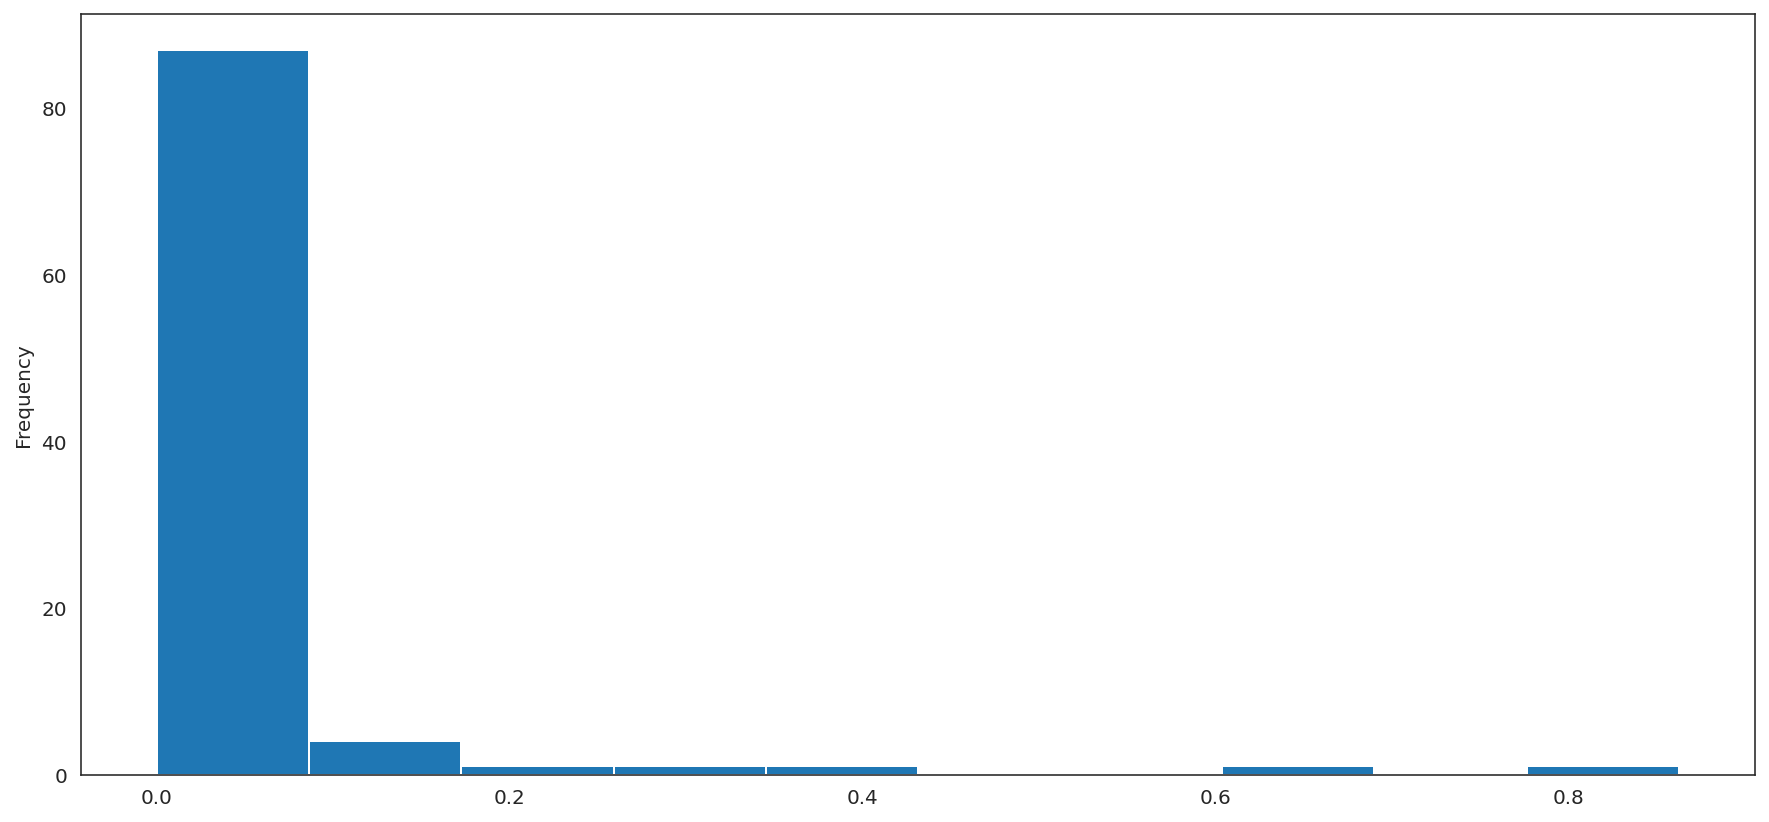

In [18]:
high_confidence_qq_pvals = results_df.iloc[:, -2]
high_confidence_qq_pvals.plot(kind='hist');

In [30]:
larger_general_validations = pd.read_csv('../data/general_larger_ts_genes.csv')
larger_general_validations.head()

,pairs4merge,beta,intercept,fold_change.transcript_remaining,pvalue.raw,pvalue.empirical,pvalue.empirical.adjusted,ENSG,gene_short_name,gRNA_group,quality_rank_grna,target_site.chr,target_site.start,target_site.stop,target_gene.chr,target_gene.start,target_gene.stop,strand,site_type,outlier_gene
0,CHR6.5150_TOP_TWO:ENSG00000055211,0.011196,-0.945562,1.011259,0.844121,not_applicable,not_applicable,ENSG00000055211,GINM1,chr6.5150_top_two,top_two,chr6,149440315,149440751,chr6,149887430,149887431,+,DHS,False
1,CHR17.6231_TOP_TWO:ENSG00000182676,0.149682,-3.060774,1.161465,0.122284,not_applicable,not_applicable,ENSG00000182676,PPP1R27,chr17.6231_top_two,top_two,chr17,80452035,80452973,chr17,79792925,79792926,-,DHS,False
2,CHR20.301_TOP_TWO:ENSG00000215251,0.046470,-2.361213,1.047567,0.511756,not_applicable,not_applicable,ENSG00000215251,FASTKD5,chr20.301_top_two,top_two,chr20,4006374,4007087,chr20,3140542,3140543,-,DHS,False
3,CHR11.882_TOP_TWO:ENSG00000166333,0.036227,-0.172435,1.036891,0.522300,not_applicable,not_applicable,ENSG00000166333,ILK,chr11.882_top_two,top_two,chr11,6715268,6715543,chr11,6624938,6624939,+,DHS,False
4,CHR12.794_TOP_TWO:ENSG00000060982,0.020666,-0.905470,1.020881,0.579733,not_applicable,not_applicable,ENSG00000060982,BCAT1,chr12.794_top_two,top_two,chr12,25486840,25487077,chr12,25056008,25056009,-,DHS,False


In [31]:
larger_general_validations.shape

(500, 20)

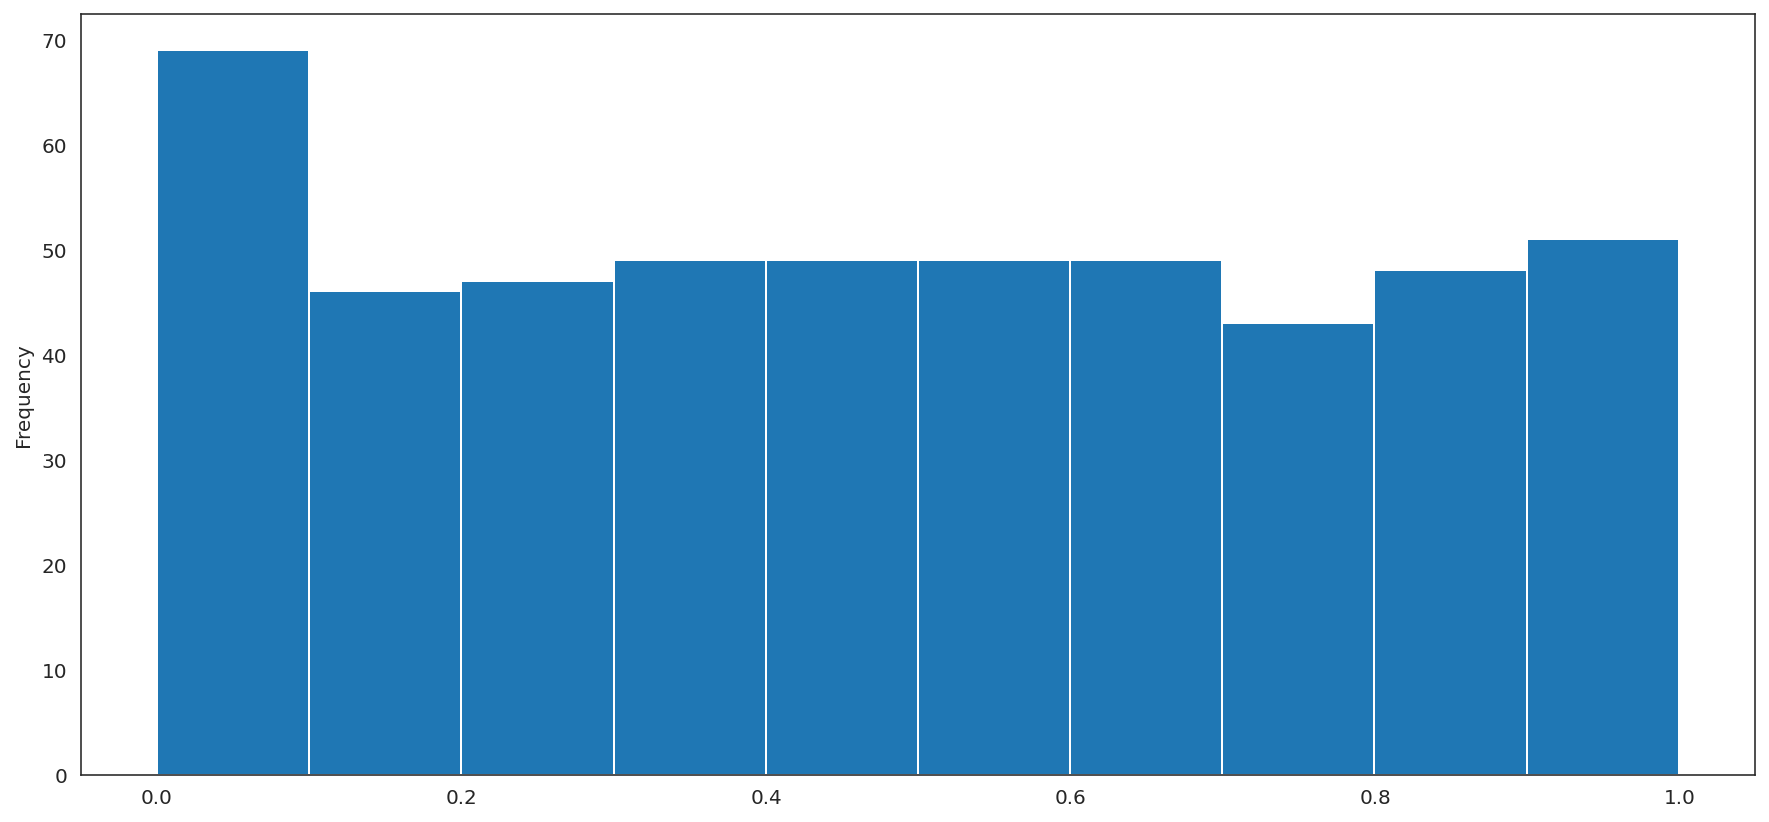

In [32]:
larger_general_validations['pvalue.raw'].plot(kind='hist');

In [33]:
larger_general_validations['ts'] = larger_general_validations['pairs4merge'].apply(lambda x: x.split(':')[0]).str.lower()
larger_general_validations['gene'] = larger_general_validations['pairs4merge'].apply(lambda x: x.split(':')[1])
larger_general_validations

,pairs4merge,beta,intercept,fold_change.transcript_remaining,pvalue.raw,pvalue.empirical,pvalue.empirical.adjusted,ENSG,gene_short_name,gRNA_group,...,target_site.start,target_site.stop,target_gene.chr,target_gene.start,target_gene.stop,strand,site_type,outlier_gene,ts,gene
0,CHR6.5150_TOP_TWO:ENSG00000055211,0.011196,-0.945562,1.011259,0.844121,not_applicable,not_applicable,ENSG00000055211,GINM1,chr6.5150_top_two,...,149440315,149440751,chr6,149887430,149887431,+,DHS,False,chr6.5150_top_two,ENSG00000055211
1,CHR17.6231_TOP_TWO:ENSG00000182676,0.149682,-3.060774,1.161465,0.122284,not_applicable,not_applicable,ENSG00000182676,PPP1R27,chr17.6231_top_two,...,80452035,80452973,chr17,79792925,79792926,-,DHS,False,chr17.6231_top_two,ENSG00000182676
2,CHR20.301_TOP_TWO:ENSG00000215251,0.046470,-2.361213,1.047567,0.511756,not_applicable,not_applicable,ENSG00000215251,FASTKD5,chr20.301_top_two,...,4006374,4007087,chr20,3140542,3140543,-,DHS,False,chr20.301_top_two,ENSG00000215251
3,CHR11.882_TOP_TWO:ENSG00000166333,0.036227,-0.172435,1.036891,0.522300,not_applicable,not_applicable,ENSG00000166333,ILK,chr11.882_top_two,...,6715268,6715543,chr11,6624938,6624939,+,DHS,False,chr11.882_top_two,ENSG00000166333
4,CHR12.794_TOP_TWO:ENSG00000060982,0.020666,-0.905470,1.020881,0.579733,not_applicable,not_applicable,ENSG00000060982,BCAT1,chr12.794_top_two,...,25486840,25487077,chr12,25056008,25056009,-,DHS,False,chr12.794_top_two,ENSG00000060982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,CHR17.2644_TOP_TWO:ENSG00000108774,0.036189,0.346507,1.036852,0.282798,not_applicable,not_applicable,ENSG00000108774,RAB5C,chr17.2644_top_two,...,40608525,40609170,chr17,40307005,40307006,-,DHS,False,chr17.2644_top_two,ENSG00000108774
496,CHR6.2480_TOP_TWO:ENSG00000137200,-0.115901,-2.433749,0.890564,0.216093,0.204619344,0.793126392638866,ENSG00000137200,CMTR1,chr6.2480_top_two,...,37079854,37080123,chr6,37400996,37400997,+,DHS,False,chr6.2480_top_two,ENSG00000137200
497,CHR5.4789_TOP_TWO:ENSG00000146066,-0.032565,1.364430,0.967959,0.262139,0.249870941,0.824784389430632,ENSG00000146066,HIGD2A,chr5.4789_top_two,...,176744851,176745398,chr5,175815748,175815749,+,DHS,False,chr5.4789_top_two,ENSG00000146066
498,CHR14.2624_TOP_TWO:ENSG00000182809,-0.062809,-4.832775,0.939123,0.842782,0.834457103,0.980907123597094,ENSG00000182809,CRIP2,chr14.2624_top_two,...,105272611,105272903,chr14,105939299,105939300,+,DHS,False,chr14.2624_top_two,ENSG00000182809


In [34]:
larger_general_validations = larger_general_validations[['ts', 'gene']]
larger_general_validations['max_iters'] = 3000
larger_general_validations.head()

/tmp/ipykernel_44722/2867028144.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  larger_general_validations['max_iters'] = 3000


,ts,gene,max_iters
0,chr6.5150_top_two,ENSG00000055211,3000
1,chr17.6231_top_two,ENSG00000182676,3000
2,chr20.301_top_two,ENSG00000215251,3000
3,chr11.882_top_two,ENSG00000166333,3000
4,chr12.794_top_two,ENSG00000060982,3000


In [35]:
in_genes_df = larger_general_validations['gene'].isin(count_matrix_df.index)
larger_general_validations = larger_general_validations[in_genes_df].reset_index(drop=True)
larger_general_validations['ts'] = larger_general_validations['ts'].str.lower()
in_cell_guide_mtx = larger_general_validations['ts'].isin(cell_ts_matrix.index)
larger_general_validations = larger_general_validations[in_cell_guide_mtx].reset_index(drop=True)

In [36]:
larger_general_validations.shape

(498, 3)

In [37]:
larger_general_validations_qq = larger_general_validations.sample(250, random_state=1)

In [38]:
general_validations_results_df = larger_general_validations_qq.apply(run_glm_optimizer, axis=1)

error output
True
False
ENSG00000178252,impdh2_tss,optimization failed
error output
False
False
ENSG00000249115,chr19.3604_top_two,optimization failed
error output
False
False
ENSG00000156983,chr3.171_top_two,optimization failed
error output
False
False
ENSG00000110881,chr12.1450_top_two,optimization failed
error output
True
False
ENSG00000141736,chr17.2442_top_two,optimization failed
error output
True
False
ENSG00000176624,chr18.1149_top_two,optimization failed
error output
True
False
ENSG00000167778,chr12.1937_top_two,optimization failed
error output
True
False
ENSG00000137200,chr6.2480_top_two,optimization failed
error output
True
False
ENSG00000168016,chr3.1280_top_two,optimization failed
error output
True
False
ENSG00000262874,chr19.5692_top_two,optimization failed
error output
True
False
ENSG00000101190,psma7_tss,optimization failed
error output
True
False
ENSG00000124772,chr6.2474_top_two,optimization failed
error output
True
False
ENSG00000104774,chr19.2014_top_two,optimization

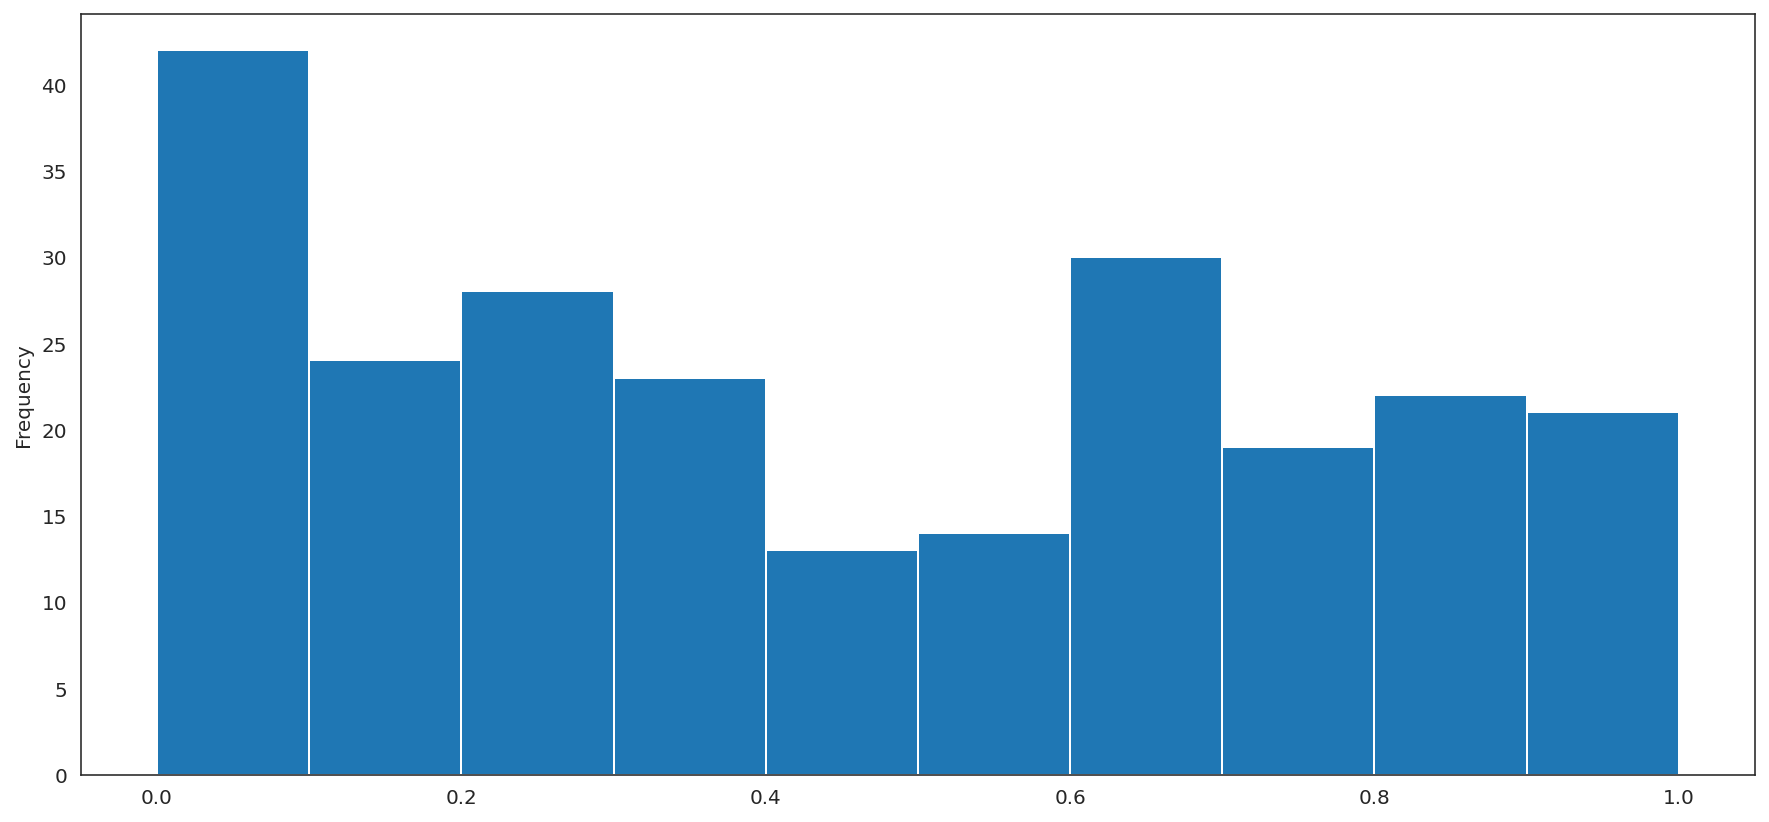

In [41]:
general_validations_qq_pvalues = general_validations_results_df.iloc[:, -2]
general_validations_qq_pvalues.plot(kind='hist');

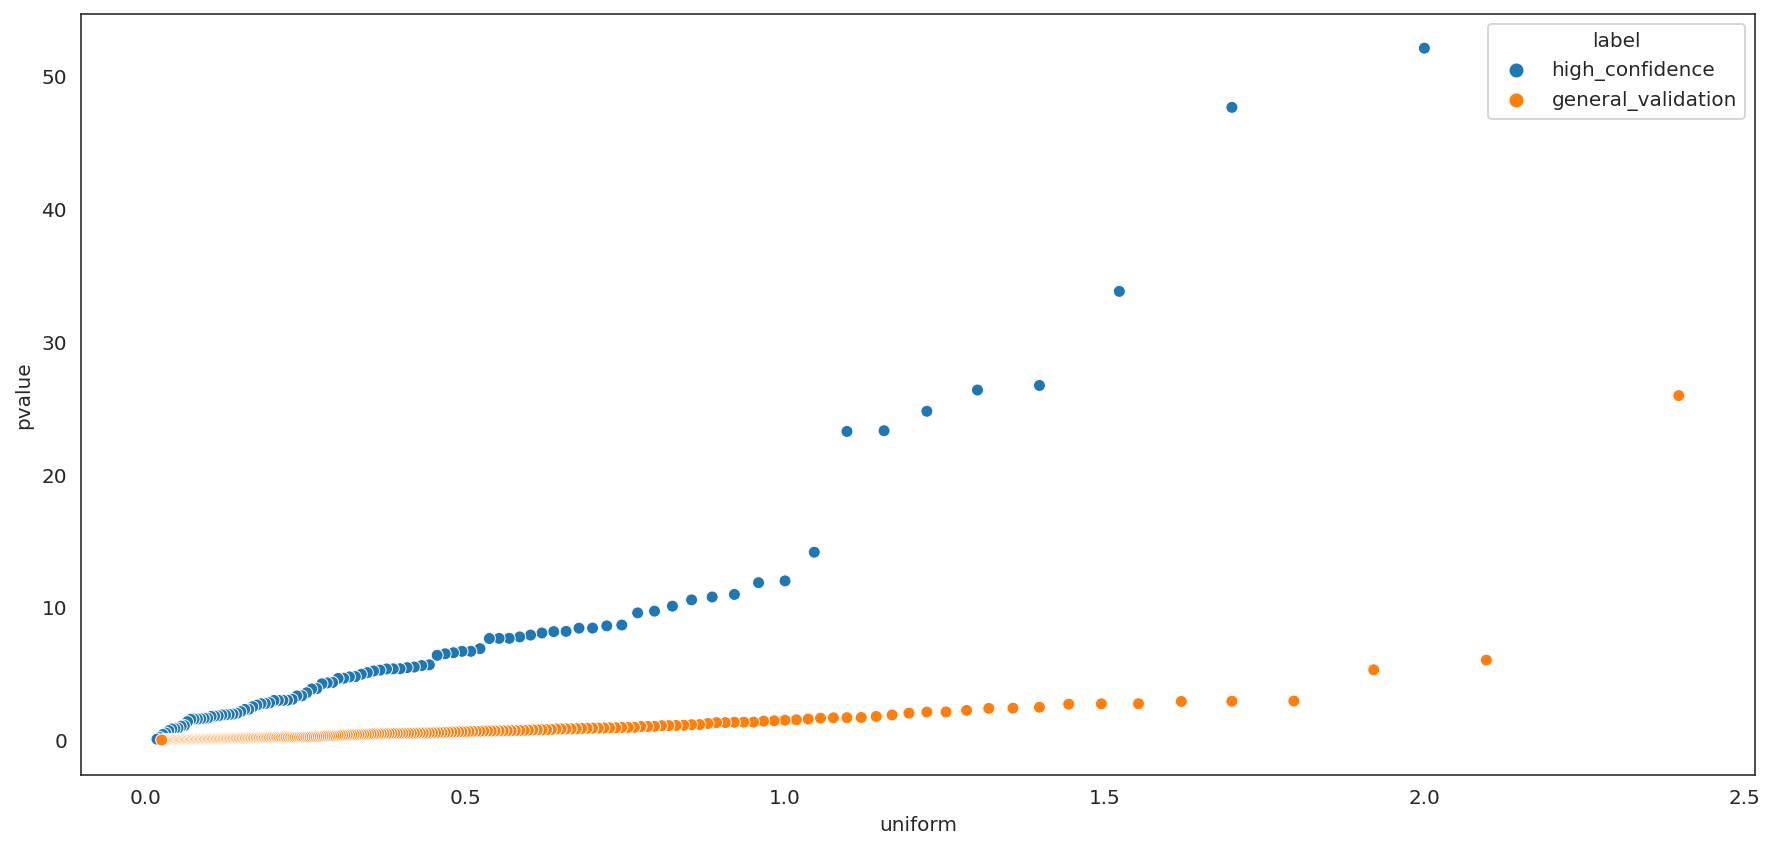

In [62]:
high_confidence_qq_df = pd.DataFrame(high_confidence_qq_pvals)
high_confidence_qq_df = high_confidence_qq_df.rename({15: 'pvalue'}, axis=1)
general_validations_qq_df = pd.DataFrame(general_validations_qq_pvalues)
general_validations_qq_df = general_validations_qq_df.rename({15: 'pvalue'}, axis=1)
high_confidence_qq_df['label'] = 'high_confidence'
general_validations_qq_df['label'] = 'general_validation'
high_confidence_qq_df = high_confidence_qq_df.sort_values(by='pvalue')
general_validations_qq_df = general_validations_qq_df.sort_values(by='pvalue')
high_confidence_qq_df['uniform'] = np.arange(1, 101) / 100
general_validations_qq_df['uniform'] = np.arange(1, 251) / 250
qq_df = pd.concat([high_confidence_qq_df, general_validations_qq_df], axis=0).reset_index(drop=True)
qq_df['uniform'] = -1 * np.log10(qq_df['uniform'])
qq_df['pvalue'] = -1 * np.log10(qq_df['pvalue'])
sns.scatterplot(data=qq_df, x='uniform', y='pvalue', hue='label');

In [61]:
high_confidence_qq_df.sort_values(by='pvalue')

,pvalue,label,uniform
422,8.526028e-53,high_confidence,0.62
322,2.438126e-48,high_confidence,0.15
411,1.712105e-34,high_confidence,0.88
275,2.079786e-27,high_confidence,0.51
305,4.581626e-27,high_confidence,0.74
...,...,...,...
456,8.624276e-01,high_confidence,0.11
246,NaN,high_confidence,0.05
368,NaN,high_confidence,0.46
341,NaN,high_confidence,0.52


In [27]:
cell_ts_matrix

cell,AAACCTGAGAGGTACC-1_1A_1_SI-GA-E2,AAACCTGCACTTCTGC-1_1A_1_SI-GA-E2,AAACCTGGTATATGAG-1_1A_1_SI-GA-E2,AAACCTGGTCTTCAAG-1_1A_1_SI-GA-E2,AAACCTGTCAGGATCT-1_1A_1_SI-GA-E2,AAACGGGAGCCATCGC-1_1A_1_SI-GA-E2,AAACGGGAGTACATGA-1_1A_1_SI-GA-E2,AAACGGGCATAAGACA-1_1A_1_SI-GA-E2,AAACGGGCATGTCCTC-1_1A_1_SI-GA-E2,AAACGGGGTGGGTCAA-1_1A_1_SI-GA-E2,...,TTTGCGCCAAAGTGCG-1_2B_8_SI-GA-H9,TTTGCGCCAAGAGTCG-1_2B_8_SI-GA-H9,TTTGCGCCACTTACGA-1_2B_8_SI-GA-H9,TTTGCGCGTAGAAGGA-1_2B_8_SI-GA-H9,TTTGCGCTCAGTACGT-1_2B_8_SI-GA-H9,TTTGGTTAGAAGCCCA-1_2B_8_SI-GA-H9,TTTGGTTAGACACTAA-1_2B_8_SI-GA-H9,TTTGGTTTCTGTCCGT-1_2B_8_SI-GA-H9,TTTGTCACAGCCAGAA-1_2B_8_SI-GA-H9,TTTGTCAGTACCTACA-1_2B_8_SI-GA-H9
chr10.845_top_two,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr1.11183_top_two,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr1.11293_top_two,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr11.1791_top_two,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr1.12598_top_two,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rbmx_tss,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
rpl31_tss,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr3.3105_top_two,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr9.1168_top_two,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
run_glm_optimizer(['chrx.952_top_two', 'ENSG00000102145', 3000])

0        13.328400
1         1.097037
2        -0.052051
3         0.044258
4        -0.005290
5        -0.028846
6        13.330128
7        -0.012601
8         1.097129
9        -0.052127
10        0.044162
11       -0.005444
12       -0.028708
13   -13684.498560
14   -13684.410850
15        0.675339
16        0.087710
dtype: float64

In [ ]:
violin_df = pd.concat([pd.Series(input_vector), pd.Series(prep_batch_1_arr), pd.Series(output_vector)], axis=1)
violin_df.columns = ['guide', 'prep_batch', 'count']
violin_df['count'] = np.log(violin_df['count'] + 0.1 / (violin_df['count'].sum() / 1000000))
# print(violin_df['count'].value_counts())
# sns.violinplot(x='guide', y='count', data=violin_df)

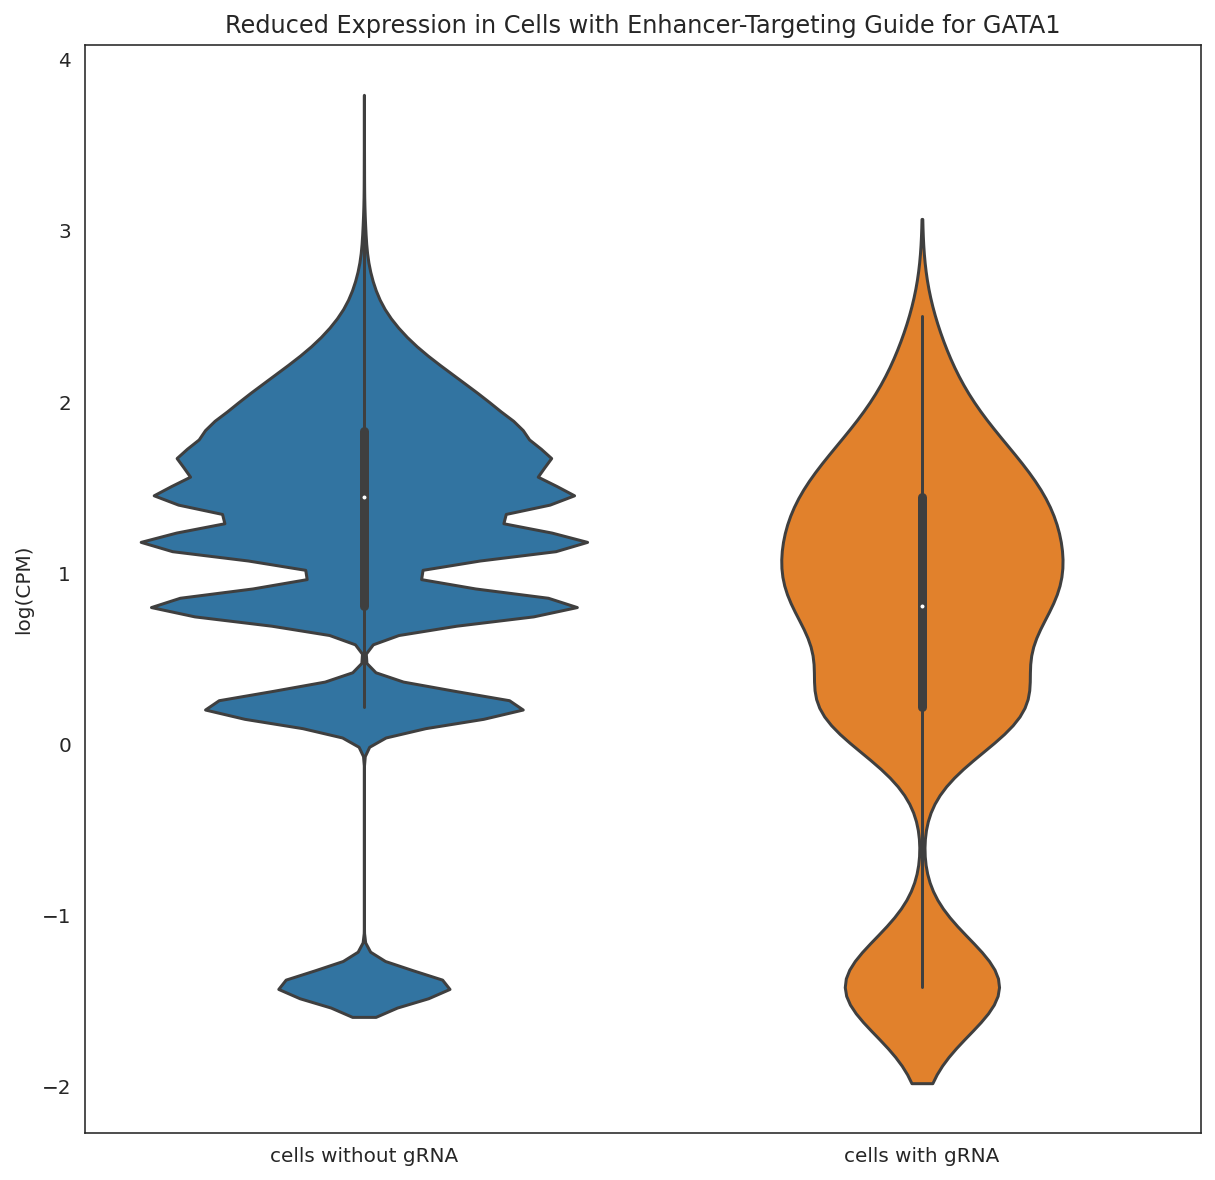

In [54]:
input_series = cell_ts_matrix.loc['chrx.952_top_two']
output_series = count_matrix_df.loc['ENSG00000102145']
violin_df = pd.merge(input_series, output_series, left_index=True, right_index=True)
violin_df.columns = ['guide', 'count']
violin_df['count'] = np.log(violin_df['count'] + 0.1 / (violin_df['count'].sum() / 1000000))

violin_df['guide'] = violin_df['guide'].replace({0: 'cells without gRNA', 1:'cells with gRNA'})
ax = sns.violinplot(data=violin_df, x='guide', y='count');
ax.set_title('Reduced Expression in Cells with Enhancer-Targeting Guide for GATA1');
ax.set_xlabel(None);
ax.set_ylabel('log(CPM)');
fig = ax.get_figure();
fig.savefig('gata1_violinplot.png');